In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob
from IPython.display import display, JSON, clear_output

In [4]:
import os
import sys
sys.path.append(os.path.abspath('../python'))

In [56]:
from EventReader import EventReader
from EventReader import show_data
from Model import SuperResolutionModel

In [6]:
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error

In [7]:
data_dir = '/mnt/c/Users/marjo/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2


In [8]:
files = glob.glob(data_dir + 'mc0001/*0000.hd5f')
events = EventReader(files)

number of files:  1


In [9]:
%%time
n = 0
nmax =5000 # if you do not want to loop over all events

true_pos = []
fine_top = []
top = []

for ev in events:
    if n%500 == 0:
        print('processed ', n, 'events')#, events.print_event(ev))
    n+=1
    
    # retrieve the true hit position
    truth = ev['true_position']
    true_pos.append(truth)
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    top.append(pmt.T)
    fine_pmt = ev['fine_top'][()]
    fine_top.append(fine_pmt.T)

    if n>nmax:
        break

events.reset()

processed  0 events
processed  500 events
processed  1000 events
processed  1500 events
processed  2000 events
processed  2500 events
processed  3000 events
processed  3500 events
processed  4000 events
processed  4500 events
processed  5000 events
CPU times: user 17.7 s, sys: 7.19 s, total: 24.9 s
Wall time: 1min 40s


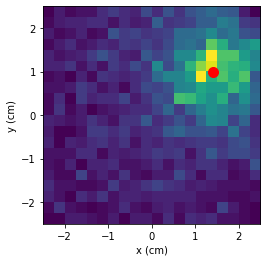

In [10]:
# check if data is ok
num = 5
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(top[num], interpolation='nearest', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax.imshow(fine_top[num], interpolation='nearest', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax.plot(true_pos[num][0], true_pos[num][1], marker='o', markersize=10, color='red', label='true position')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()

In [11]:
# create train and test sets
y = fine_top
X = top
pos = [pos[:2] for pos in true_pos]

train_ratio = 0.8
n_train = int(train_ratio*len(X))

X_train = np.asarray(X[:n_train])
y_train = np.asarray(y[:n_train])
pos_train = np.asarray(pos[:n_train])

X_test = np.asarray(X[n_train:])
y_test = np.asarray(y[n_train:])
pos_test = np.asarray(pos[n_train:])

In [12]:
# Flatten the input and output arrays
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
y_train_flattened = y_train.reshape(y_train.shape[0], -1)
pos_train_flattened = pos_train.reshape(pos_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
y_test_flattened = y_test.reshape(y_test.shape[0], -1)
pos_test_flattened = pos_test.reshape(pos_test.shape[0], -1)


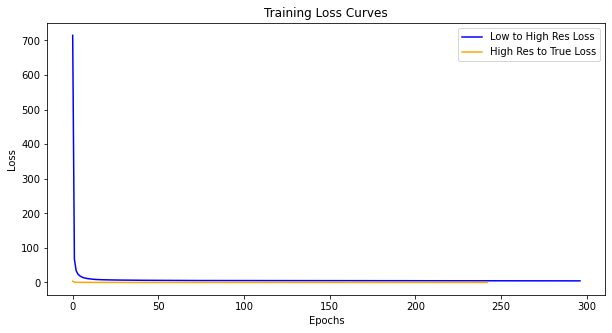

In [13]:
model1 = SuperResolutionModel()
model1.train(X_train_flattened, y_train_flattened, pos_train_flattened)
model1.plot_loss_curve()

In [51]:
def downsample_heatmaps_to_dimensions(heatmaps, new_height, new_width):
    """
    Downsample a list of heatmaps to specified dimensions using averaging.

    Args:
        heatmaps (list of numpy.ndarray): List of high-resolution heatmaps.
        new_height (int): The desired height of the downsampled heatmaps.
        new_width (int): The desired width of the downsampled heatmaps.

    Returns:
        list of numpy.ndarray: List of downsampled heatmaps.
    """
    downsampled_heatmaps = []

    for heatmap in heatmaps:
        # Get the dimensions of the original heatmap
        height, width = heatmap.shape

        # Reshape the heatmap to a 4D tensor for pooling
        heatmap_4d = heatmap.reshape((1, 1, height, width))

        # Calculate the scale factors for downsampling
        scale_factor_height = height // new_height
        scale_factor_width = width // new_width

        # Perform average pooling using np.mean
        downsampled_heatmap_4d = np.mean(heatmap_4d.reshape((1, 1, new_height, scale_factor_height, new_width, scale_factor_width)), axis=(3, 5))

        # Reshape the downsampled heatmap to the desired dimensions
        downsampled_heatmap = downsampled_heatmap_4d.reshape((new_height, new_width))

        downsampled_heatmaps.append(downsampled_heatmap)

    return downsampled_heatmaps



In [52]:

y_train_downsampled = downsample_heatmaps_to_dimensions(y_train, 5, 5)
y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, 5, 5)
y_train_downsampled_flattened = np.asarray(y_train_downsampled).reshape(y_train.shape[0], -1)
y_test_downsampled_flattened = np.asarray(y_test_downsampled).reshape(y_test.shape[0], -1)
model2 = SuperResolutionModel()
model2.train(X_train_flattened, y_train_downsampled_flattened, pos_train_flattened)

In [53]:
# Check the model
print(model1.predict(X_train_flattened[0].reshape(1, -1)))
print(model1.evaluate(X_test_flattened, y_test_flattened, pos_test))
print(model2.evaluate(X_test_flattened, y_test_downsampled_flattened, pos_test))

[[ 0.41854022 -0.44962194]]
{'MSE': 0.19750191857447869, 'R^2': 0.924058039238502}
{'MSE': 0.19716655212437656, 'R^2': 0.9241869918379411}


In [54]:
# Create and train the single-step model
single_step_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500)
single_step_model.fit(X_train_flattened, pos_train)

# Evaluate the single-step model
single_step_model_metrics = {
    'MSE': mean_squared_error(pos_test_flattened, single_step_model.predict(X_test_flattened)),
    'R^2': single_step_model.score(X_test_flattened, pos_test)
}
print(single_step_model_metrics)


{'MSE': 0.9264491084692363, 'R^2': 0.6398585760980727}


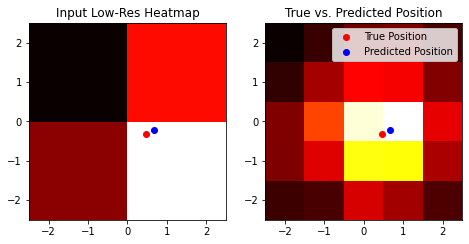

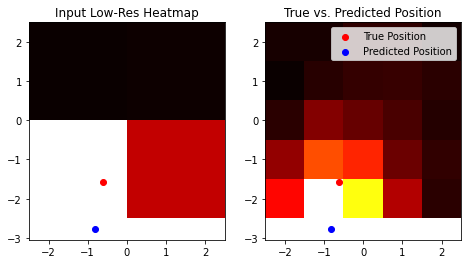

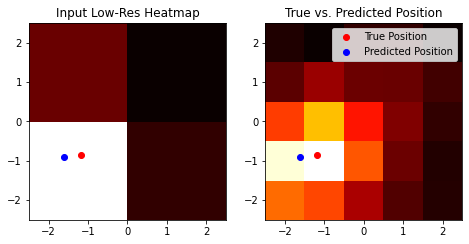

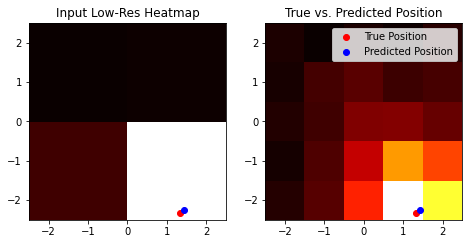

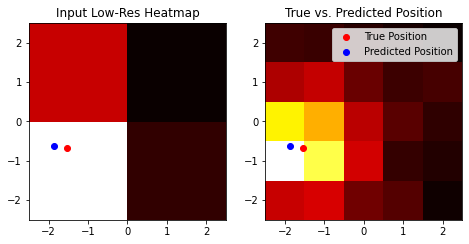

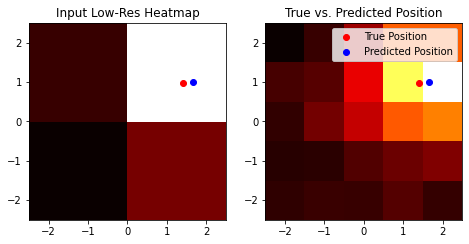

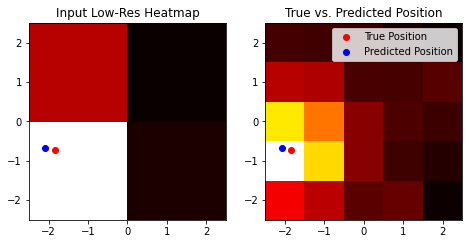

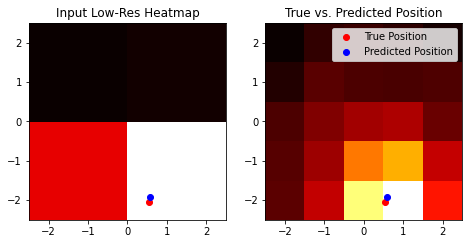

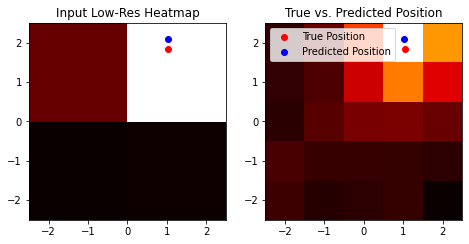

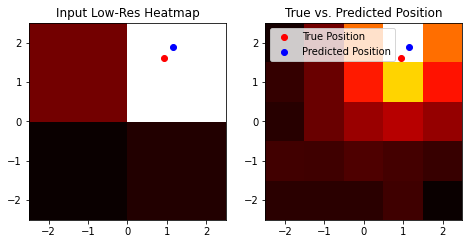

In [57]:
model2.visualize_heatmaps_with_positions(X_train_flattened, pos_train)

ValueError: cannot reshape array of size 400 into shape (10,10)

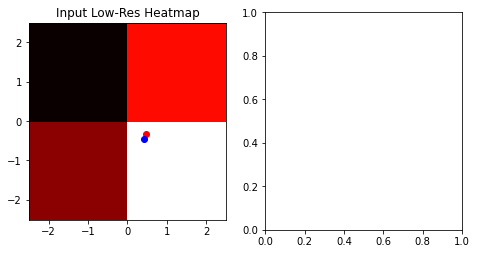

In [55]:
model1.visualize_heatmaps_with_positions(X_train_flattened, pos_train)

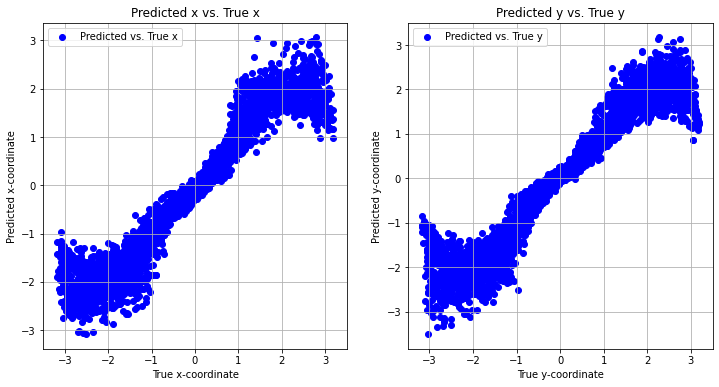

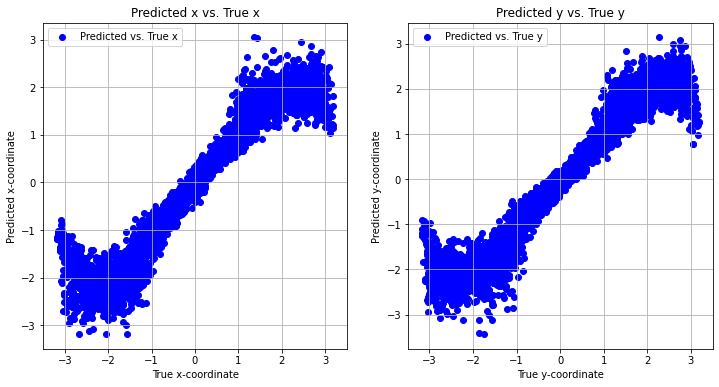

In [58]:
model1.visualize_x_vs_true_x(X_train_flattened, pos_train)
model2.visualize_x_vs_true_x(X_train_flattened, pos_train)

In [18]:
# train SUPER RESOLUTION MODEL
# Create and train the MLPRegressor model
model_sr = MLPRegressor(hidden_layer_sizes=(256, 124), activation='relu', solver='adam', random_state=42, early_stopping=True)
model_sr.fit(X_train_flattened, y_train_flattened)

# Evaluate the model
train_score = model_sr.score(X_train_flattened, y_train_flattened)
test_score = model_sr.score(X_test_flattened, y_test_flattened)

print('Training score:', train_score)
print('Testing score:', test_score)

Training score: 0.7478575955455699
Testing score: 0.7464072187281446


/home/marjolein/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


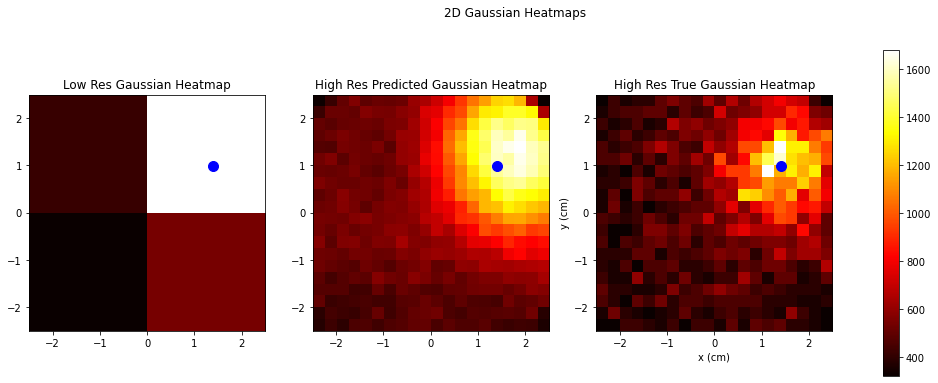

In [ ]:
def plot_res(num):
    # Plot the heatmap
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    im1 = ax[0].imshow(X_train_flattened[num].reshape((2,2)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[0].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    im2 = ax[1].imshow(model_sr.predict(X_train_flattened)[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[1].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    im3 = ax[2].imshow(y_train_flattened[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
    ax[2].scatter(pos_train[num][0], pos_train[num][1], marker='o', color='blue', s=100)
    
    # Create a colorbar object
    cbar = plt.colorbar(im1, ax=ax)

    ax[0].set_title('Low Res Gaussian Heatmap')
    ax[1].set_title('High Res Predicted Gaussian Heatmap')
    ax[2].set_title('High Res True Gaussian Heatmap')
    plt.suptitle('2D Gaussian Heatmaps')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.show()
plot_res(5)

In [ ]:
# HIGH RES TO POSITION MODEL

model_pos = MLPRegressor(hidden_layer_sizes=(256, 124), activation='relu', solver='adam', random_state=42, early_stopping=True)
model_pos.fit(y_train_flattened, pos_train_flattened)

# Evaluate the model
train_score = model_pos.score(y_train_flattened, pos_train_flattened)
test_score = model_pos.score(y_test_flattened, pos_test_flattened)
print('Training score:', train_score)
print('Testing score:', test_score)

Training score: 0.9780544815240464
Testing score: 0.8522673417387893


/home/marjolein/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
Predicted_pos = model_pos.predict(model_sr.predict(X_train_flattened))

IndexError: index 1301 is out of bounds for axis 0 with size 800

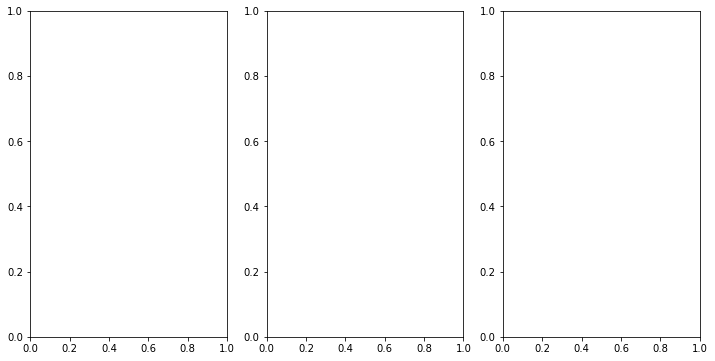

In [ ]:
num = 1301

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(y_train_flattened[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[0].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[0].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

ax[1].imshow(model_sr.predict(X_train_flattened)[num].reshape((20,20)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[1].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[1].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

ax[2].imshow(X_train_flattened[num].reshape((2,2)), cmap='hot', origin='lower', extent=[-2.5, 2.5, -2.5, 2.5])
ax[2].plot(Predicted_pos[num][0], Predicted_pos[num][1], c='black', marker = 'o', markersize=10, label='predicted position')
ax[2].plot(pos_train[num][0], pos_train[num][1], c='b', marker = 'x', markersize=10, label='true position')

plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()


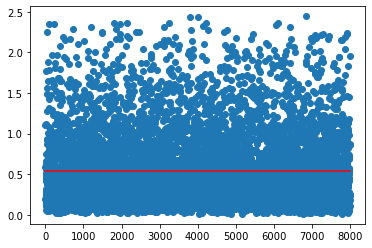

In [ ]:
avg_err = np.mean(np.linalg.norm(Predicted_pos-pos_train, axis=1))
errs = []
for num in range(8000):
    errs.append(np.linalg.norm(Predicted_pos[num]-pos_train[num]))

plt.scatter(range(8000), errs)
plt.plot([0,8000], [avg_err, avg_err], c='r')